# Aufgabe 1 - k-NN Klassifikation

## Teilaufgabe a)

Wenn die Attribute sich stark in ihrer Größenordnung unterscheiden, muss auf eine nicht zu große Wahl von $k$ geachtet werden.
Denn wird $k$ zu groß gewählt, besteht die Gefahr, Punkte mit großem Abstand zu $x$ in die Klassifikation mit einzubeziehen. 
Dies drückt sich durch eine Zunahme der Erwartungstreue (Bias) aus. 
Dieses Problem kann mit einer gewichteten Abstandsfunktion gelöst werden.

## Teilaufgabe b)

Beim k-NN Algorithmus erfolgt die Modellbildung nicht während oder nach dem Trainieren (lazy learner). 
Die Trainingsdaten werden einfach abgespeichert, was zu einem großen Speicheraufwand führt.
Die Laufzeit der Lernphase ist dadurch jedoch relativ kurz.

Erst zur Zeit der Abfrage findet die Modellbildung lokal in der Umgebung des Arbeitspunktes statt (lazy learner). Bei einem Datenset mit vielen Attributen führt das zu langen Rechenzeiten in der Anwendungsphase.

Je nachdem wie der Algorithmus gestalltet wird ergeben sich unterschiedliche Laufzeiten. 
Mit der der Anzahl der Traningselemete $n$, deren Dimension $d$ und einem fest gewählten $k$ ergibt sich folgendes. 
Jede Abstandsberechnung erfordert $O(d)$ Rechenschritte.
Wird als erstes der Abstand des neuen Elements zu den $n$ Trainingselementen berechnet und dann die $k$ nächsten Nachbarn bestimmt, ergibt sich für die Laufzeit $O(nd + kn)$. 
Wenn während der Auswahl der $k$ nächsten Nachbarn der Abstand zu den $n$ Trainingselementen berechnet wird, folgt für die Laufzeit $O(ndk)$.

## Teilaufgabe c)

In [1]:
import numpy as np
import pandas as pd
import scipy # Vektorisierte Funktion,
#um schnell den Abstand zwischen einer Menge an Punkten zu bestimmen und in einer Matrix zu speichern
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [6]:
class KNN:
    '''KNN Classifier.

    Attributes
    ----------
    k : int
        Number of neighbors to consider.
    '''
    def __init__(self, k):
        '''Initialization.
        Parameters are stored as member variables/attributes.
        
        Parameters
        ----------
        k : int
            Number of neighbors to consider.
        '''
        self.k = k

    def fit(self, X, y):
        '''Fit routine.
        Training data is stored within object.
        
        Parameters
        ----------
        X : numpy.array, shape=(n_samples, n_attributes)
            Training data.
        y : numpy.array shape=(n_samples)
            Training labels.
        '''
        self.training_data = X
        self.training_labels = y

    def predict(self, X):
        '''Prediction routine.
        Predict class association of each sample of X.
        
        Parameters
        ----------
        X : numpy.array, shape=(n_samples, n_attributes)
            Data to classify.
        
        Returns
        -------
        prediction : numpy.array, shape=(n_samples)
            Predictions, containing the predicted label of each sample.
        '''
        
        # First we need to find a few parameters
        n_attributes, n_samples = X.shape
        n_training_data = np.size(self.training_data, axis = 1) # this means finding the amount of columns
        
        prediction = []
        
        for i in range(X.shape[0]): # für jeden zu klassifizierenden Datenpunkt
            back = 0 # ein Counter für die Anzahl der nächsten Nachbarn, die Background-Ereignisse sind
            sig = 0 # und nochmal für die Signal-nächsten-Nachbarn
            a = X[i] # keine Veränderung von Arrays in For Loops in Python, deswegen ein temporäres Objekt
            if len(a.shape) != 2: # mache eben aus a ein 2d-Array mit nur einer Zeile, falls es noch keins ist.
                a = a.reshape(1, a.shape[0])
            distanceTest = scipy.spatial.distance.cdist(a, self.training_data)[0] # Hierfür MUESSEN beide Arrays zweidimensional sein
            distanceList = np.stack((distanceTest, self.training_labels), axis=-1) # Klebe die beiden Arrays als Spalten zusammen!
            sortedDistanceList = distanceList[distanceList[:,0].argsort()] # Sortiere nach der ersten Spalte!
            kNearestNeighbors = sortedDistanceList[:self.k] # Nimm nur die ersten k Werte -> k nächste Nachbarn
            for l in range(0, self.k):
                if kNearestNeighbors[l,1] == 0:
                    back += 1
                else:
                    sig +=1
            if back > sig:
                prediction.append(0)
            elif back < sig:
                prediction.append(1)
            else:
                prediction.append(0) # Falls gleich viele Signale und Background in der Nachbarschaft liegen
                # können wir keine Entscheidung treffen...
        return np.asarray(prediction) # Gib ein numpy Array zurück, weil man damit besser arbeiten kann als mit einer Liste

## Teilaufgabe d)
Der selbst geschriebene KNN-Klassifikator wird an dem NeutrinoMC-Beispiel getestet.
Wir definieren zunächst einige Funktionen und analysieren die Daten. Die Ergebnisse sind zufriedenstellend, KNN kann die Daten recht gut zuordnen. Dies wird auch grafisch veranschaulicht.

In [7]:
def getDataFromFile(filename, key, log = False):
    '''Gets the hits, x and y from a NeutrinoMC-file, cuts any nans and returns them as a numpy matrix
    If getDataFromFile is invoked with log = True the decadic logarithm of the hits will be used.'''
    hdf = pd.read_hdf(filename, key)
    hits = hdf.NumberOfHits
    x = hdf.x
    y = hdf.y
    hits = np.asarray(hits)
    if log == True:
        hits = np.log10(hits)
    hits = hits[~np.isnan(hits)] # ~ means not 
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    y = np.asarray(y)
    y = y[~np.isnan(y)]
    return np.transpose(np.matrix([hits, x, y])) # Wir wollen die Attribute des Punktes x_i in der i-ten Zeile haben


def getKNNData(matrixSignal, matrixBackground, lenTraining, lenSignal, lenBackground, shuffle = False, seed = 0):
    '''Takes two Matrizes matrixSignal and matrixBackground. Returns three numpy arrays:
    TrainingData contains 2*lenTraining points. TrainingData[0:lenTraining] is the background data used to train the knn classifier,
    TrainingData[lenTraining:2lenTraining] is the signal data used to train.
    TestDataSignal contains lenSignal signal points to test the model, TestDataBackground is analogous.
    If getKNNData is invoked with shuffle = True the given data is shuffled randomly with a function from sklearn.'''
    if shuffle == True:
        matrixSignal, matrixBackground = shuffle(matrixSignal, matrixBackground, random_state=seed)
    matrixSignal = matrixSignal[:lenTraining+lenSignal:,] # Nimm bitte die ersten lenTraining+lenSignal
    matrixBackground = matrixBackground[:lenTraining+lenBackground:,]
    
    trainingDataBackground, testDataBackground = np.split(matrixBackground, [lenTraining])
    trainingDataSignal, testDataSignal = np.split(matrixSignal, [lenTraining])
    trainingData = np.concatenate((trainingDataBackground, trainingDataSignal), axis=0)
    
    return trainingData, testDataBackground, testDataSignal

In [8]:
lenTraining = 5000
lenSignal = 10000
lenBackground = 20000
k = 10

matrixSignal = getDataFromFile(filename='NeutrinoMC.hdf5', key='Signal')
matrixBackground = getDataFromFile(filename='NeutrinoMC.hdf5', key='Background')
trainingData, testDataBackground, testDataSignal = getKNNData(matrixSignal, matrixBackground,
                                                              lenTraining, lenSignal, lenBackground)
labels = np.concatenate((np.zeros(lenTraining),np.ones(lenTraining))) # 0 = Background, 1 = Signal

In [9]:
knn = KNN(10)
knn.fit(trainingData, labels)
labelsSig = knn.predict(testDataSignal)
labelsBack = knn.predict(testDataBackground)

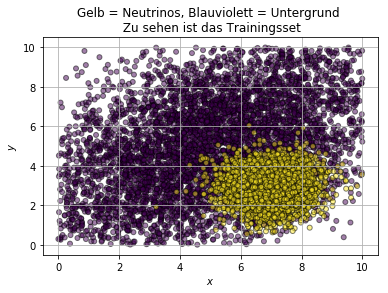

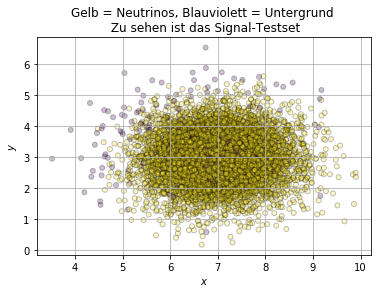

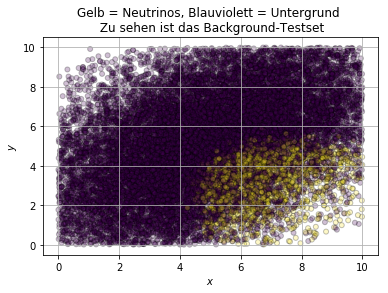

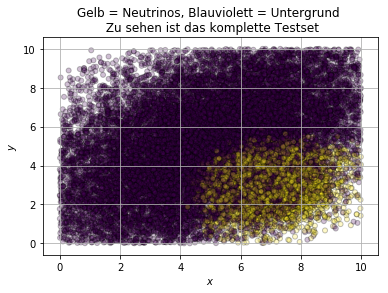

In [11]:
xTrain = trainingData[:,1]
xTrain = np.ravel(xTrain)
yTrain = trainingData[:,2]
yTrain = np.ravel(yTrain)
xSig = testDataSignal[:,1]
xSig = np.ravel(xSig)
ySig = testDataSignal[:,2]
ySig = np.ravel(ySig)
xBack = testDataBackground[:,1]
xBack = np.ravel(xBack)
yBack = testDataBackground[:,2]
yBack = np.ravel(yBack)

plt.scatter(xTrain, yTrain, marker='o', c = labels, alpha = 0.5,
            s=25, edgecolor='k')
plt.title('Gelb = Neutrinos, Blauviolett = Untergrund \n Zu sehen ist das Trainingsset')
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()
plt.clf()

plt.scatter(xSig, ySig, marker='o', c = labelsSig, alpha = 0.25,
            s=25, edgecolor='k')
plt.title('Gelb = Neutrinos, Blauviolett = Untergrund \n Zu sehen ist das Signal-Testset')
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()
plt.clf()

plt.scatter(xBack, yBack, marker='o', c = labelsBack, alpha = 0.25,
            s=25, edgecolor='k')
plt.title('Gelb = Neutrinos, Blauviolett = Untergrund \n Zu sehen ist das Background-Testset')
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()
plt.clf()

plt.scatter(xSig, ySig, marker='o', c = labelsSig, alpha = 0.25,
            s=25, edgecolor='k')
plt.scatter(xBack, yBack, marker='o', c = labelsBack, alpha = 0.25,
            s=25, edgecolor='k')
plt.title('Gelb = Neutrinos, Blauviolett = Untergrund \n Zu sehen ist das komplette Testset')
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()
plt.clf()

In [12]:
def classifyData(k, trainingData, labels, testDataSignal, testDataBackground):
    '''Analyzes a given Testset based on trainingdata and labels. Uses knn with k nearest neighbors.
    Results (tp, fn, fp, tn, precision, recall and significance) are printed to screen.'''
    knn = KNN(k)
    knn.fit(trainingData, labels)
    predictionS = knn.predict(testDataSignal)
    predictionB = knn.predict(testDataBackground)
    predictionS = np.asarray(predictionS)
    predictionB = np.asarray(predictionB)
    tp = np.count_nonzero(predictionS == 1) # Neutrinos, die korrekt als Neutrino zugeordnet werden
    fn = np.count_nonzero(predictionS == 0) # Neutrinos, die fälschlicherweise als Background zugeordnet werden
    fp = np.count_nonzero(predictionB == 1) # Background, der fälschlicherweise als Neutrino zugeordnet wird
    tn = np.count_nonzero(predictionB == 0) # Background, der korrekt als Background zugeordnet wird
    print('tp', tp)
    print('fn', fn)
    print('fp', fp)
    print('tn', tn)
    Reinheit = tp/(tp+fp)
    Effizienz = tp/(tp+fn)
    Signifikanz = tp/(np.sqrt(tp+fp))
    print('Reinheit =', Reinheit)
    print('Effizienz =', Effizienz)
    print('Signifikanz =', Signifikanz)

In [13]:
classifyData(k, trainingData, labels, testDataSignal, testDataBackground)

tp 9679
fn 321
fp 1824
tn 18176
Reinheit = 0.8414326697383291
Effizienz = 0.9679
Signifikanz = 90.2453700219


## Teilaufgabe e)
Wir verwenden nun $\mathrm{log}_{10}$(Hits) statt Hits. Das führt zu einer verbesserten Zuordnung der Daten, da alle Qualitätsmaße verbessert werden. Es wurden nur noch 1,2% statt 2,6% der Neutrinos fälschlicherweise dem Background zugeordnet. Man kann das Logarithmieren der Hits als eine Art Skalierung oder Normierung verstehen, da dann die Größenordnungen der Attribute ähnlicher werden und allen drei Attributen eine ähnlichere Wichtigkeit zukommt.

In [14]:
matrixSignal = getDataFromFile(filename='NeutrinoMC.hdf5', key='Signal', log=True)
matrixBackground = getDataFromFile(filename='NeutrinoMC.hdf5', key='Background', log=True)
trainingData, testDataBackground, testDataSignal = getKNNData(matrixSignal, matrixBackground,
                                                              lenTraining, lenSignal, lenBackground)

In [15]:
classifyData(k, trainingData, labels, testDataSignal, testDataBackground)

tp 9734
fn 266
fp 1299
tn 18701
Reinheit = 0.8822623039970996
Effizienz = 0.9734
Signifikanz = 92.6711458174


## Teilaufgabe f)
Nun wird $k=20$ gewählt. Es ist zu erkennen, dass die Analyse ohne den Logarithmus streng schlechter ist.
Mit dem Logarithmus ist es schwieriger: Es werden mehr Neutrinos korrekt zugeordnet als mit $k=10$, ober die Zuordnung der Background-Events im Testset wird schlechter. Dies resultiert in einer geringeren Reinheit, aber in einer leicht besseren Effizienz.<br>
Man müsste weitere Werte für $k$ untersuchen, um genauere Schlüsse zu ziehen; jedoch kann man vermuten, dass in der Nähe von $k=20$ Underfitting vorliegt. Wenn zu viele nächste Nachbarn untersucht werden, wird die Analyse geglättet und unsensitiver für den Input (Beispiel: Wählt man zum Beispiel $k$ als Größe des Testsets wäre der Output konstant und unabhängig von den Attributwerten). Wie gesagt müsste man die Qualitätsmaße in Abhängigkeit von $k$ allerdings genauer untersuchen, um auch nur annäherend sichere Aussagen über die beste Wahl von $k$ zu treffen.

In [16]:
k = 20

In [17]:
matrixSignal = getDataFromFile(filename='NeutrinoMC.hdf5', key='Signal')
matrixBackground = getDataFromFile(filename='NeutrinoMC.hdf5', key='Background')
trainingData, testDataBackground, testDataSignal = getKNNData(matrixSignal, matrixBackground,
                                                              lenTraining, lenSignal, lenBackground)
labels = np.concatenate((np.zeros(lenTraining),np.ones(lenTraining))) # 0 = Background, 1 = Signal
classifyData(k, trainingData, labels, testDataSignal, testDataBackground)

tp 9656
fn 344
fp 2054
tn 17946
Reinheit = 0.8245943637916311
Effizienz = 0.9656
Signifikanz = 89.2316265501


In [18]:
matrixSignal = getDataFromFile(filename='NeutrinoMC.hdf5', key='Signal', log=True)
matrixBackground = getDataFromFile(filename='NeutrinoMC.hdf5', key='Background', log=True)
trainingData, testDataBackground, testDataSignal = getKNNData(matrixSignal, matrixBackground,
                                                              lenTraining, lenSignal, lenBackground)
classifyData(k, trainingData, labels, testDataSignal, testDataBackground)

tp 9809
fn 191
fp 1465
tn 18535
Reinheit = 0.8700549937910236
Effizienz = 0.9809
Signifikanz = 92.38165096
